<a href="https://colab.research.google.com/github/ShuHuiK/WIE3007_Group_Assignment/blob/shuhui_2/Neural_Network_Model_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

MODULE EVALUATION METRICS
              precision    recall  f1-score   support

  No Default       0.97      0.89      0.93       282
     Default       0.23      0.50      0.31        18

    accuracy                           0.87       300
   macro avg       0.60      0.70      0.62       300
weighted avg       0.92      0.87      0.89       300

ROC AUC Score: 0.8219
F1 Score:      0.3103


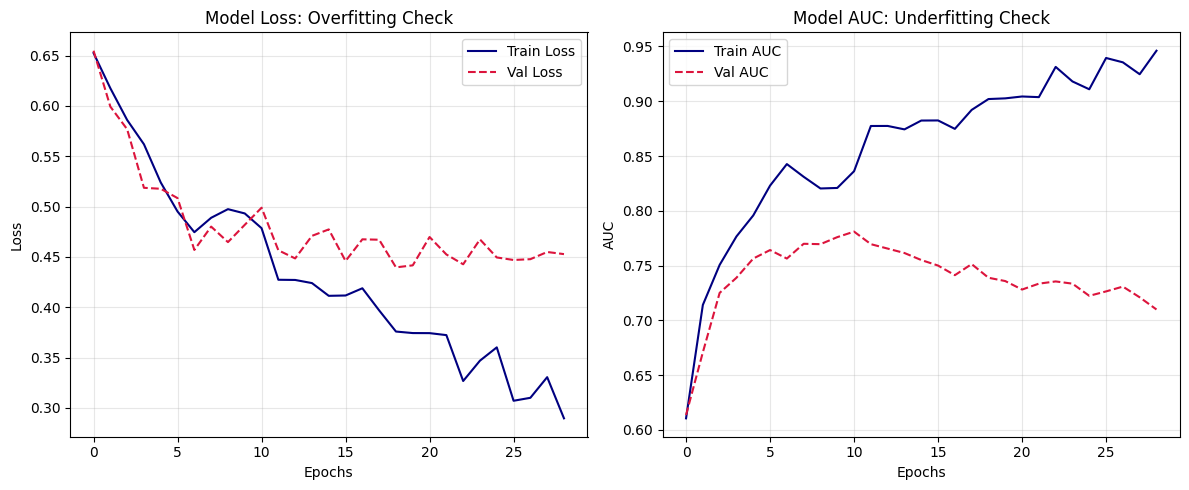


Calculating Feature Importance (Manual Permutation)...


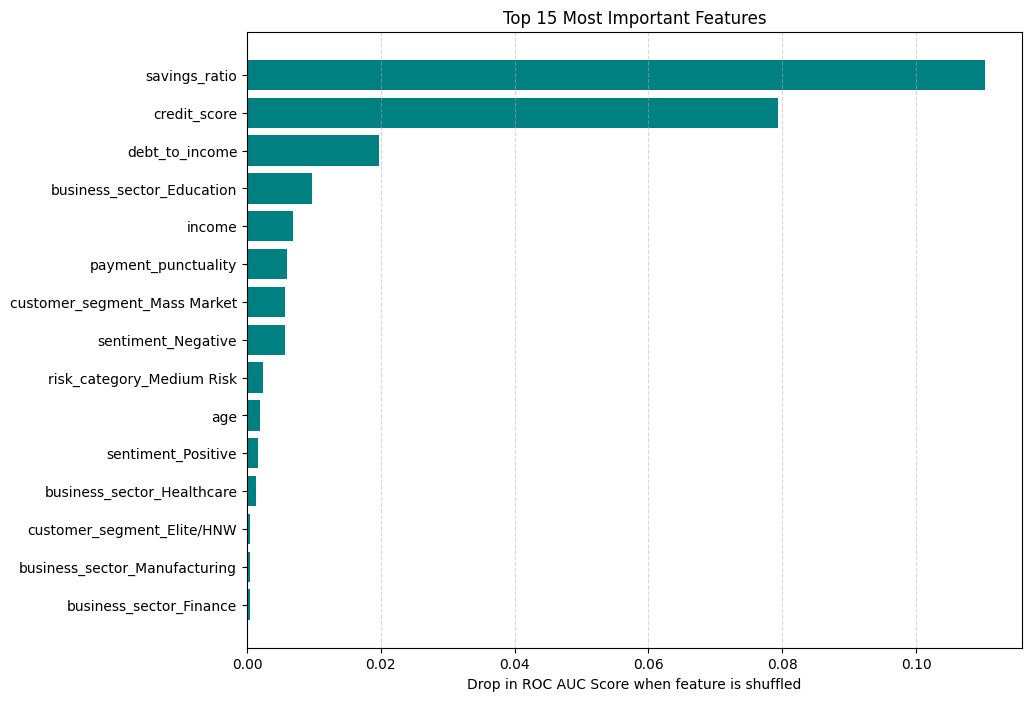

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. LOAD DATA
df = pd.read_csv('2025_Sterling_Financial_Dataset_clean.csv')

# 2. PREPROCESSING
# Dropping non-predictive columns
drop_cols = ['date', 'customer_id', 'customer_feedback', 'location']
X = df.drop(columns=['default_history'] + drop_cols)
y = df['default_history']

# Defining numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Creating the transformer pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Fit and transform
X_processed = preprocessor.fit_transform(X)

# 3. SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y.values, test_size=0.2, random_state=42, stratify=y
)

# 4. HANDLE CLASS IMBALANCE
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}

# 5. BUILD NEURAL NETWORK
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# 6. TRAIN MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=0
)

# 7. EVALUATION
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n" + "="*30)
print("MODULE EVALUATION METRICS")
print("="*30)
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

auc_val = roc_auc_score(y_test, y_pred_prob)
f1_val = f1_score(y_test, y_pred)

print(f"ROC AUC Score: {auc_val:.4f}")
print(f"F1 Score:      {f1_val:.4f}")

# ==========================================
# 8. CHECK FOR UNDERFITTING OR OVERFITTING
# ==========================================

# Dynamically find keys to avoid KeyError (e.g. 'auc' vs 'auc_1' vs 'AUC')
auc_key = [k for k in history.history.keys() if 'auc' in k.lower() and 'val' not in k.lower()][0]
val_auc_key = [k for k in history.history.keys() if 'auc' in k.lower() and 'val' in k.lower()][0]

plt.figure(figsize=(12, 5))

# Plot Loss (Overfitting Check)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='navy')
plt.plot(history.history['val_loss'], label='Val Loss', color='crimson', linestyle='--')
plt.title('Model Loss: Overfitting Check')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot AUC (Underfitting Check)
plt.subplot(1, 2, 2)
plt.plot(history.history[auc_key], label='Train AUC', color='navy')
plt.plot(history.history[val_auc_key], label='Val AUC', color='crimson', linestyle='--')
plt.title('Model AUC: Underfitting Check')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# ==========================================
# 9. FEATURE IMPORTANCE (Manual Permutation)
# ==========================================

print("\nCalculating Feature Importance (Manual Permutation)...")

# 1. Get baseline score
baseline_auc = roc_auc_score(y_test, model.predict(X_test, verbose=0))
importances = []

# 2. Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()
clean_names = [name.split('__')[-1] for name in feature_names]

# 3. Loop through features, shuffle them, and measure the drop in AUC
# Note: Using a copy of X_test to avoid corrupting original data
X_test_permute = X_test.copy()

for i in range(X_test.shape[1]):
    save_col = X_test_permute[:, i].copy()

    # Shuffle only this column
    np.random.seed(42)
    np.random.shuffle(X_test_permute[:, i])

    # Predict and calculate new AUC
    y_perm_prob = model.predict(X_test_permute, verbose=0)
    perm_auc = roc_auc_score(y_test, y_perm_prob)

    # Importance is the drop in AUC
    importances.append(baseline_auc - perm_auc)

    # Restore the column for the next iteration
    X_test_permute[:, i] = save_col

# 4. Create DataFrame and Plot
importance_df = pd.DataFrame({
    'Feature': clean_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
top_n = 15
plt.barh(importance_df['Feature'][-top_n:], importance_df['Importance'][-top_n:], color='teal')
plt.xlabel('Drop in ROC AUC Score when feature is shuffled')
plt.title(f'Top {top_n} Most Important Features')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()